Here is some data wrangling and EDA, not sure what exactly to do but I figured it would be a good start 


In [1]:
# Imports 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import re 
import matplotlib.pyplot as plt

We read in the Rankings csv file and clean it and extract the columns we want so we can use it to filter the college_data dataframe. 

In [2]:
# Importing data 
college_data = pd.read_csv("2018_2019_College_Data.csv")
rankings = pd.read_csv("CWUR_2018-2019.csv")

# Gathering Ranking data we need to filter the Scorecard data
rankings = rankings[rankings['Location'] == 'USA']
rankings = rankings.loc[:,['Institution','National Rank']]
rankings = rankings.reset_index(drop=True)

/var/folders/3p/y0vk1fkd5sngg7zjfqnb2sv80000gn/T/ipykernel_80667/368511839.py:2: DtypeWarning: Columns (1729,1909,1910,1911,1912,1913,2376,2377,2958) have mixed types. Specify dtype option on import or set low_memory=False.
  college_data = pd.read_csv("2018_2019_College_Data.csv")


In [3]:
rankings.head()

,Institution,National Rank
0,Harvard University,1
1,Stanford University,2
2,Massachusetts Institute of Technology,3
3,"University of California, Berkeley",4
4,Princeton University,5


This funciton will standardize the institutions and allow us to include only our ranked universities based off the CWUR dataset. 

In [4]:
# Standardizes instritution, used for filtering Scorecard data based on ranking data
def institution_standardize(string):
    string = string.lower()
    string = string.replace(',', '')
    string = string.replace(' ', '')
    string = re.sub(r'[^a-zA-Z0-9]', '', string)
    return string

Now, we'll change the column datatypes to strings and standardize both institution columns. Changing the columns to string types will ensure we can properly filter our College Scorecard dataset. 

In [5]:
# Standardizing ranking data
rankings['Institution'] = rankings['Institution'].apply(institution_standardize)
rankings['Institution'] = rankings["Institution"].astype('string')

# Creating copy dataframe, so we can use this to filter our original data with the original institution names
college_data_filter = college_data.copy()

# Standardizing copy Scorecard data
college_data_filter['INSTNM'] = college_data_filter['INSTNM'].apply(institution_standardize)
college_data_filter['INSTNM'] = college_data_filter['INSTNM'].astype('string')

Now that both institution cols have been standardized, we can filter the college dataset using the national rankings dataset. 

In [6]:
filtered_college_data = college_data_filter[college_data_filter['INSTNM'].isin(rankings['Institution'])]

After filtering out the universities we arent interested in, we now have to sort the data based off the national rankings so we have an ascending rank in our dataframe. 

In [7]:
# Convert the list of institutions to a categorical data type with the desired order
filtered_college_data['INSTNM'] = pd.Categorical(filtered_college_data['INSTNM'], categories=rankings['Institution'], ordered=True)

# Sort the dataframe based on the ordered 'INSTNM' column
college_sorted = filtered_college_data.sort_values(by='INSTNM')


/var/folders/3p/y0vk1fkd5sngg7zjfqnb2sv80000gn/T/ipykernel_80667/3966034804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_college_data['INSTNM'] = pd.Categorical(filtered_college_data['INSTNM'], categories=rankings['Institution'], ordered=True)


In [8]:
college_sorted.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,DCS_PELL_LOAN,PCTPELL_DCS_POOLED_SUPP,PCTFLOAN_DCS_POOLED_SUPP,DCS_PELL_LOAN_POOLED,POOLYRS_DCS,SATVR50,SATMT50,ACTCM50,ACTEN50,ACTMT50
1492,166027,215500,2155,harvarduniversity,Cambridge,MA,02138,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3841,243744,130500,1305,stanforduniversity,Stanford,CA,94305,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1508,166683,217800,2178,massachusettsinstituteoftechnology,Cambridge,MA,02139-4307,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,110635,131200,1312,universityofcaliforniaberkeley,Berkeley,CA,94720,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2046,186131,262700,2627,princetonuniversity,Princeton,NJ,08544-0070,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The copy data has now been sorted by rank, so now we can use this to pull the data we need, using the indices of the univeristies, and the dired columns we want to extract. we'll aslo add a column to our dataframe with the national ranking of each school.

In [9]:
desired_cols = [
    'INSTNM','COSTT4_A','BOOKSUPPLY','GRAD_DEBT_MDN','PCT75_EARN_WNE_P8','PCT25_EARN_WNE_P8','MD_EARN_WNE_P6','MD_EARN_WNE_P10'
    ]

indices = college_sorted.index.to_list()

college_data = college_data.iloc[indices]

college_data = college_data.loc[:,desired_cols]
college_data = college_data.dropna().reset_index(drop=True)
college_data['NationalRank'] = college_data.index + 1

numeric_cols = ['COSTT4_A','BOOKSUPPLY','GRAD_DEBT_MDN', 'PCT75_EARN_WNE_P8', 'PCT25_EARN_WNE_P8','MD_EARN_WNE_P6','MD_EARN_WNE_P10', 'NationalRank']
college_data[numeric_cols] = college_data[numeric_cols].astype(float)

college_data.rename(
    columns={
        'INSTNM': 'institution',
        'COSTT4_A': 'avg_cost', 
        'BOOKSUPPLY': 'supply_cost',
        'GRAD_DEBT_MDN':'avg_debt',
        'PCT75_EARN_WNE_P8':'75%_earnings_8_yrs',
        'PCT25_EARN_WNE_P8':'25%_earnings_8_yrs',
        'MD_EARN_WNE_P6': 'earnings_6_yrs',
        'MD_EARN_WNE_P10':'earnings_10_yrs',
        'NationalRank':'rank'
        }
        , inplace=True
        )

In [10]:
college_data

,institution,avg_cost,supply_cost,avg_debt,75%_earnings_8_yrs,25%_earnings_8_yrs,earnings_6_yrs,earnings_10_yrs,rank
0,Harvard University,71135.0,1000.0,13750.0,135753.0,45980.0,77816.0,84918.0,1.0
1,Stanford University,69109.0,1455.0,11750.0,166805.0,58448.0,88873.0,97798.0,2.0
2,Massachusetts Institute of Technology,67430.0,800.0,12500.0,169114.0,75080.0,112623.0,111222.0,3.0
3,University of California-Berkeley,36739.0,849.0,13478.0,117722.0,44547.0,65914.0,80364.0,4.0
4,Princeton University,66950.0,1050.0,10750.0,147835.0,56354.0,84713.0,95689.0,5.0
...,...,...,...,...,...,...,...,...,...
141,University of Memphis,22676.0,1569.0,25000.0,58368.0,25544.0,36243.0,43699.0,142.0
142,Amherst College,71300.0,1000.0,13500.0,117651.0,40980.0,54333.0,71567.0,143.0
143,Missouri University of Science and Technology,22012.0,838.0,24250.0,91060.0,43854.0,65427.0,80289.0,144.0
144,University of North Carolina at Greensboro,19779.0,1312.0,22695.0,55495.0,28133.0,36963.0,44195.0,145.0


In [11]:
college_data.to_csv('filtered_2018_2019_college_data.csv')

<Axes: xlabel='rank', ylabel='avg_cost'>

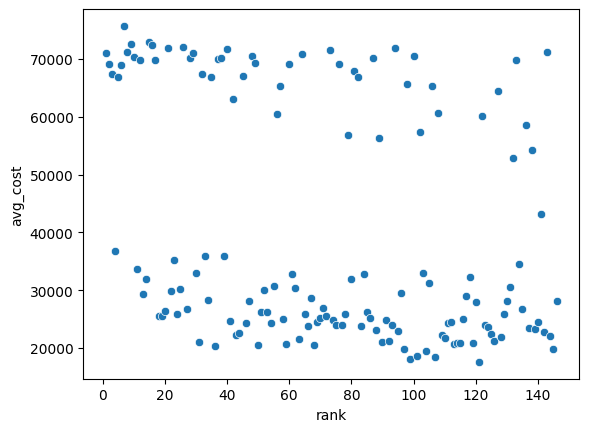

In [12]:
# Comparing rank and average cost 
sns.scatterplot( data = college_data, x = 'rank', y = 'avg_cost')

<Axes: xlabel='avg_cost', ylabel='earnings_10_yrs'>

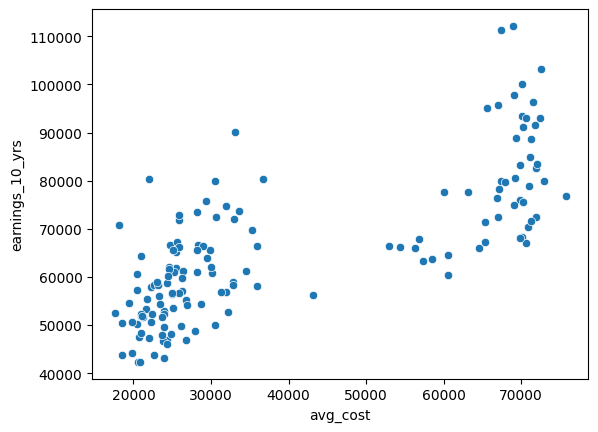

In [13]:
# Comparing cost of attendance to median earnings after 10 years 
sns.scatterplot( data = college_data, x = 'avg_cost', y = 'earnings_10_yrs')

<Axes: xlabel='rank', ylabel='earnings_10_yrs'>

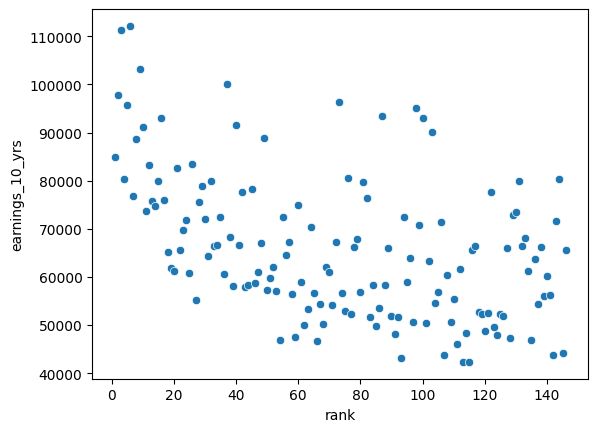

In [14]:
# Comapring rank and median earnings after 10 years
sns.scatterplot( data = college_data, x = 'rank', y = 'earnings_10_yrs')

<Axes: xlabel='rank', ylabel='75%_earnings_8_yrs'>

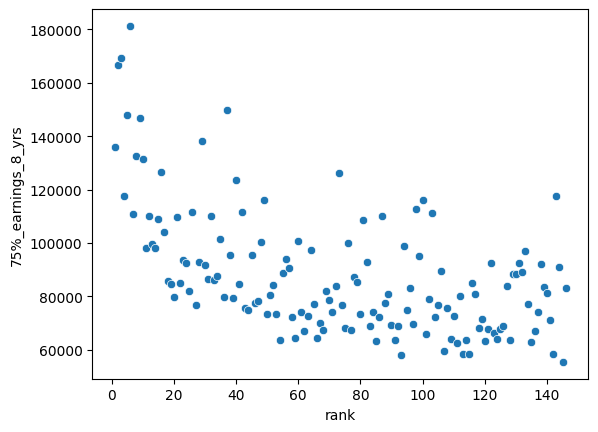

In [15]:
sns.scatterplot( data = college_data, x = 'rank', y = '75%_earnings_8_yrs')

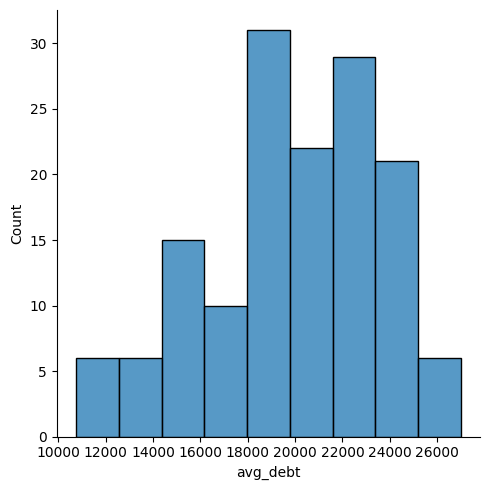

In [16]:
sns.displot(college_data['avg_debt'])

<Axes: xlabel='avg_cost', ylabel='Count'>

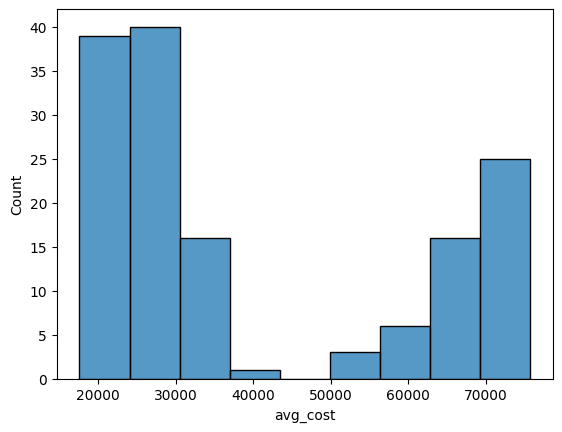

In [17]:
sns.histplot(college_data['avg_cost'])


<Axes: xlabel='25%_earnings_8_yrs', ylabel='Count'>

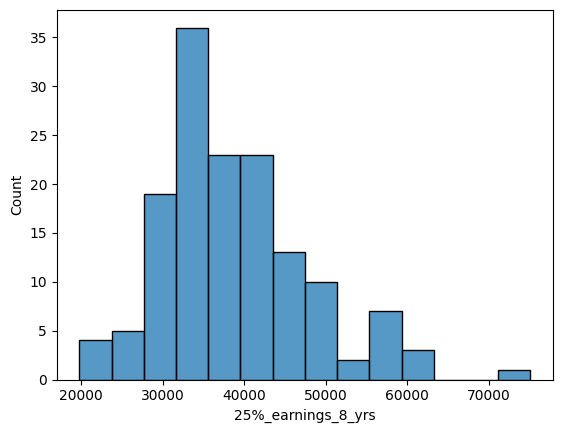

In [18]:
sns.histplot(college_data['25%_earnings_8_yrs'])


<Axes: xlabel='earnings_10_yrs', ylabel='Count'>

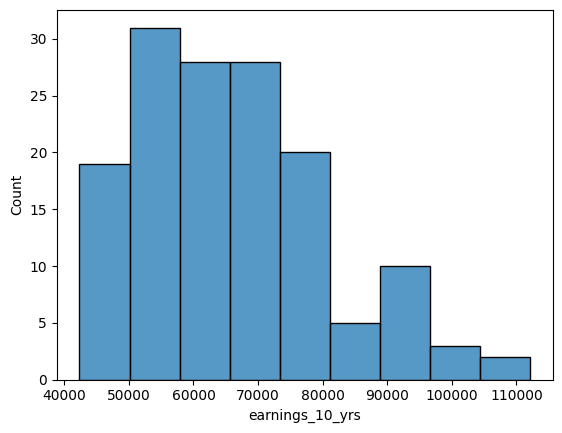

In [19]:
sns.histplot(college_data['earnings_10_yrs'])


<Axes: xlabel='75%_earnings_8_yrs', ylabel='Count'>

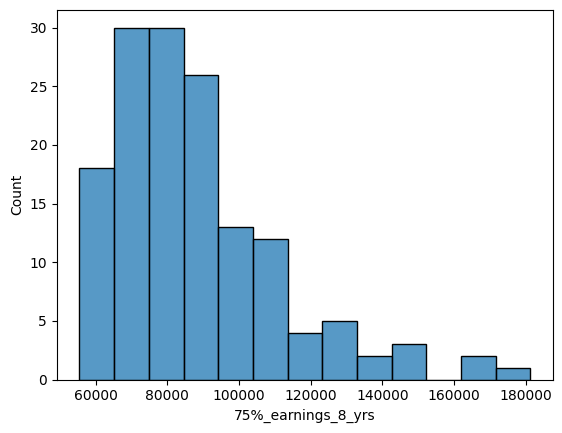

In [20]:
sns.histplot(college_data['75%_earnings_8_yrs'])


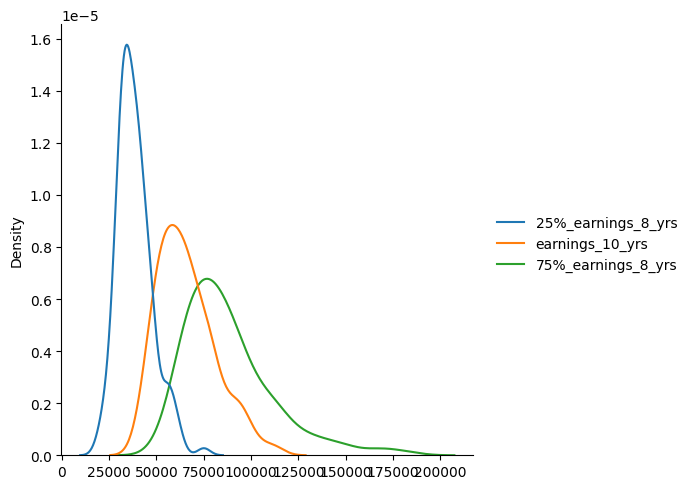

In [21]:
sns.displot(college_data[['25%_earnings_8_yrs', 'earnings_10_yrs', '75%_earnings_8_yrs']], kind='kde')
